In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
from google.colab import drive
drive.mount('/content/drive')

root_path = 'drive/MyDrive/NBA-predictions'

Mounted at /content/drive


In [3]:
train_data = pd.read_csv(root_path +'/data/train_data_ppmadf.csv')
test_data= pd.read_csv(root_path +'/data/test_data_ppmadf.csv')

X_train = train_data.drop(columns=['HOME_WIN'])
y_train = train_data['HOME_WIN']

X_test = test_data.drop(columns=['HOME_WIN'])
y_test = test_data['HOME_WIN']

In [4]:
def get_season_by_year(year=2013, df=train_data):
  '''
  year = int
    NOTE: year = 2013, 2014, 2015 (due to dataset limitations)

  df = all_games by default

  Returns dataframe with games filtered by year.
  '''
  # Note: This function should be cleaned up to allow for more dynamic input
  # This is a quick implementation

  temp_df = df.copy()
  
  # pandas allows us to use strings to filter datetimes
  # we will use August 8th as the month and day to filter by season
  min_date = str(year) + '-08-08'
  max_date = str(year+1) + '-08-08'

  temp_df = temp_df.drop(temp_df[temp_df.GAME_DATE > max_date].index)
  temp_df = temp_df.drop(temp_df[temp_df.GAME_DATE < min_date].index)
  
  return temp_df

In [5]:
def plot_confidence(y_test, y_preds, y_probs, bins=30, graph_range=(-1,0)):
  '''
  Plots predict_proba as a histogram.

  Note: The prediction probability is for HOME_WIN = 1, therefore the ideal graph would have most of its data centered around 40-60%.
    a 20% incorrect prediction for the HOME_WIN = 1 (when it should be 0) is the same magnitude of error as an 80% for predicting HOME_WIN = 0 (when it should be 1)

  '''
  import seaborn as sns
  import matplotlib.pyplot as plt
  sns.set(rc={'figure.figsize':(20, 8)})

  hist_data = pd.DataFrame()
  hist_data['TRUTH'] = y_test
  hist_data['PROBS'] = y_probs
  hist_data['PREDS'] = y_preds

  graph_col = list()
  for row in range(len(hist_data)):
    if hist_data.iloc[row].TRUTH == hist_data.iloc[row].PREDS: # the TRUTH matches the PREDICTION, append a POSITIVE PROBS
      graph_col.append(hist_data.iloc[row].PROBS)
    else:
      graph_col.append(hist_data.iloc[row].PROBS * (-1)) # the TRUTH does NOT match the PREDICTION, append a NEGATIVE PROBS

  hist_data['GRAPH'] = graph_col

  plt.hist([hist_data['GRAPH']], color=['blue'], bins=bins, range=graph_range)

  df_filter = hist_data.GRAPH < 0
  print('Mean confidence of error: ' + str(hist_data[df_filter]['GRAPH'].mean()))
  total_incorrect = hist_data[df_filter]['GRAPH'].count()

  df_filter = (hist_data.GRAPH < (-0.65)) | ((hist_data.GRAPH > (-0.35)) & (hist_data.GRAPH < (0)))
  print('Number of "strongly" incorrect (greater than 65% probability): ' + str(hist_data[df_filter]['GRAPH'].count()) + ' of ' + str(total_incorrect) + ' total incorrect.')
  
  return

## Logistic Regression Model 1: 
# BASELINE
## Input Data:


1.   TEAM_1_ABBREVIATION (i.e. "MIA" for Miami Heat)
2.   TEAM_2_ABBREVIATION (i.e. "SAS" for San Antonio Spurs)

## Output Data:

1.   HOME_WIN (1 : YES, 0 : NO)




In [6]:
train_data = pd.read_csv(root_path +'/data/train_data_ppmadf.csv')
test_data= pd.read_csv(root_path +'/data/test_data_ppmadf.csv')

X_train = train_data.drop(columns=['HOME_WIN'])
y_train = train_data['HOME_WIN']

X_test = test_data.drop(columns=['HOME_WIN'])
y_test = test_data['HOME_WIN']

In [7]:
baseline_columns = list()

for i in X_train.columns[:60]:
  #print(i)
  baseline_columns.append(i)

X_train_bl = X_train[baseline_columns]
X_test_bl = X_test[baseline_columns]

In [8]:
# simple logistic regression model used as a baseline classifier
clf = LogisticRegression(random_state=101).fit(X_train_bl, y_train)

In [9]:
preds = clf.predict(X_test_bl)
probs = clf.predict_proba(X_test_bl)[:,1]

In [10]:
clf.score(X_test_bl, y_test)

0.6300813008130082

Mean confidence of error: -0.5241396268619515
Number of "strongly" incorrect (greater than 65% probability): 217 of 455 total incorrect.


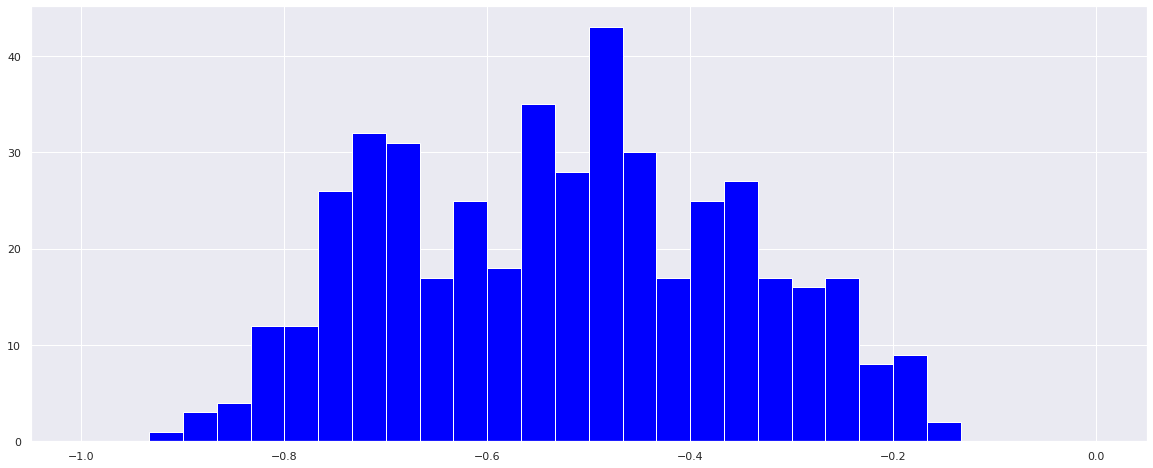

In [11]:
plot_confidence(y_test, preds, probs)

## Logistic Regression Model 2: 
# Historic Team Data

In [12]:
# Let's revisit this with our updated database

df = pd.read_csv(root_path +'/data/2013_ppdf.csv')
df.head()

,GAME_DATE,GAME_ID,MATCHUP,HOME_TEAM,AWAY_TEAM,HOME_PREV_SEAS_WIN_PERC,HOME_PREV_SEAS_AVG_PTS_PER_GAME,HOME_PREV_SEAS_FG_PERC,HOME_PREV_SEAS_THREE_PERC,HOME_PREV_SEAS_FREE_THROW_PERC,HOME_PREV_SEAS_PLUS_MINUS,AWAY_PREV_SEAS_WIN_PERC,AWAY_PREV_SEAS_AVG_PTS_PER_GAME,AWAY_PREV_SEAS_FG_PERC,AWAY_PREV_SEAS_THREE_PERC,AWAY_PREV_SEAS_FREE_THROW_PERC,AWAY_PREV_SEAS_PLUS_MINUS,HOME_WIN
0,10/29/2013,21300001,ORL @ IND,IND,ORL,0.605,94.7,43.6,34.7,74.6,4.0,0.244,94.1,44.8,32.9,75.5,-7.0,1
1,10/29/2013,21300003,LAC @ LAL,LAL,LAC,0.549,102.2,45.8,35.5,69.2,1.2,0.683,101.1,47.8,35.8,71.1,6.5,1
2,10/29/2013,21300002,CHI @ MIA,MIA,CHI,0.805,102.9,49.6,39.6,75.4,7.9,0.549,93.2,43.7,35.3,77.3,0.3,1
3,10/30/2013,21300015,POR @ PHX,PHX,POR,0.305,95.2,44.3,33.0,74.4,-6.5,0.402,97.5,44.8,35.3,77.6,-3.2,1
4,10/30/2013,21300016,DEN @ SAC,SAC,DEN,0.341,100.2,44.7,36.3,76.9,-4.9,0.695,106.1,47.8,34.3,70.1,5.1,1


In [13]:
columns_list = df.columns.to_list()[5:]
columns_list
# columns_list = columns_list.remove('GAME_DATE')
# columns_list = columns_list.remove('MATCHUP')
# columns_list = columns_list.remove('MATCHUP')
# columns_list = columns_list.remove('MATCHUP')
# columns_list = columns_list.remove('MATCHUP')

['HOME_PREV_SEAS_WIN_PERC',
 'HOME_PREV_SEAS_AVG_PTS_PER_GAME',
 'HOME_PREV_SEAS_FG_PERC',
 'HOME_PREV_SEAS_THREE_PERC',
 'HOME_PREV_SEAS_FREE_THROW_PERC',
 'HOME_PREV_SEAS_PLUS_MINUS',
 'AWAY_PREV_SEAS_WIN_PERC',
 'AWAY_PREV_SEAS_AVG_PTS_PER_GAME',
 'AWAY_PREV_SEAS_FG_PERC',
 'AWAY_PREV_SEAS_THREE_PERC',
 'AWAY_PREV_SEAS_FREE_THROW_PERC',
 'AWAY_PREV_SEAS_PLUS_MINUS',
 'HOME_WIN']

In [14]:
AWAY_TEAM_DICT = {
    'ATL' : 'AWAY_ATL',
    'BKN' : 'AWAY_BKN',
    'BOS' : 'AWAY_BOS', 
    'CHA' : 'AWAY_CHA', 
    'CHI' : 'AWAY_CHI', 
    'CLE' : 'AWAY_CLE', 
    'DAL' : 'AWAY_DAL', 
    'DEN' : 'AWAY_DEN', 
    'DET' : 'AWAY_DET', 
    'GSW' : 'AWAY_GSW', 
    'HOU' : 'AWAY_HOU', 
    'IND' : 'AWAY_IND', 
    'LAC' : 'AWAY_LAC', 
    'LAL' : 'AWAY_LAL', 
    'MEM' : 'AWAY_MEM', 
    'MIA' : 'AWAY_MIA', 
    'MIL' : 'AWAY_MIL', 
    'MIN' : 'AWAY_MIN', 
    'NOP' : 'AWAY_NOP', 
    'NYK' : 'AWAY_NYK', 
    'OKC' : 'AWAY_OKC', 
    'ORL' : 'AWAY_ORL', 
    'PHI' : 'AWAY_PHI', 
    'PHX' : 'AWAY_PHX', 
    'POR' : 'AWAY_POR', 
    'SAC' : 'AWAY_SAC', 
    'SAS' : 'AWAY_SAS', 
    'TOR' : 'AWAY_TOR', 
    'UTA' : 'AWAY_UTA', 
    'WAS' : 'AWAY_WAS',  
}
AWAY_TEAM = pd.get_dummies(df.AWAY_TEAM)
AWAY_TEAM = AWAY_TEAM.rename(columns=AWAY_TEAM_DICT)

HOME_TEAM = pd.get_dummies(df.HOME_TEAM)

df_model = pd.concat((
    HOME_TEAM, 
    AWAY_TEAM,
    df[columns_list]
), axis=1)


In [15]:
df_model

,ATL,BKN,BOS,CHA,CHI,CLE,DAL,DEN,DET,GSW,HOU,IND,LAC,LAL,MEM,MIA,MIL,MIN,NOP,NYK,OKC,ORL,PHI,PHX,POR,SAC,SAS,TOR,UTA,WAS,AWAY_ATL,AWAY_BKN,AWAY_BOS,AWAY_CHA,AWAY_CHI,AWAY_CLE,AWAY_DAL,AWAY_DEN,AWAY_DET,AWAY_GSW,AWAY_HOU,AWAY_IND,AWAY_LAC,AWAY_LAL,AWAY_MEM,AWAY_MIA,AWAY_MIL,AWAY_MIN,AWAY_NOP,AWAY_NYK,AWAY_OKC,AWAY_ORL,AWAY_PHI,AWAY_PHX,AWAY_POR,AWAY_SAC,AWAY_SAS,AWAY_TOR,AWAY_UTA,AWAY_WAS,HOME_PREV_SEAS_WIN_PERC,HOME_PREV_SEAS_AVG_PTS_PER_GAME,HOME_PREV_SEAS_FG_PERC,HOME_PREV_SEAS_THREE_PERC,HOME_PREV_SEAS_FREE_THROW_PERC,HOME_PREV_SEAS_PLUS_MINUS,AWAY_PREV_SEAS_WIN_PERC,AWAY_PREV_SEAS_AVG_PTS_PER_GAME,AWAY_PREV_SEAS_FG_PERC,AWAY_PREV_SEAS_THREE_PERC,AWAY_PREV_SEAS_FREE_THROW_PERC,AWAY_PREV_SEAS_PLUS_MINUS,HOME_WIN
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.605,94.7,43.6,34.7,74.6,4.0,0.244,94.1,44.8,32.9,75.5,-7.0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.549,102.2,45.8,35.5,69.2,1.2,0.683,101.1,47.8,35.8,71.1,6.5,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.805,102.9,49.6,39.6,75.4,7.9,0.549,93.2,43.7,35.3,77.3,0.3,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.305,95.2,44.3,33.0,74.4,-6.5,0.402,97.5,44.8,35.3,77.6,-3.2,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.341,100.2,44.7,36.3,76.9,-4.9,0.695,106.1,47.8,34.3,70.1,5.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.732,105.7,48.1,37.7,82.8,9.2,0.354,94.9,44.9,35.6,69.9,-4.0,1
1226,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.341,100.2,44.7,36.3,76.9,-4.9,0.305,95.2,44.3,33.0,74.4,-6.5,0
1227,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.463,98.9,43.5,36.0,73.6,-1.5,0.537,98.0,46.4,37.1,71.5,0.4,0
1228,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.402,97.5,44.8,35.3,77.6,-3.2,0.683,101.1,47.8,35.8,71.1,6.5,1


In [16]:
X = df_model.drop(columns=['HOME_WIN'])
y = df_model['HOME_WIN']

In [17]:
from sklearn import preprocessing
mms = preprocessing.MinMaxScaler()
temp_df = X.copy()
for i in temp_df.columns[60:]:
  #print(i)
  X[i] = mms.fit_transform(temp_df[i].values.reshape(-1,1))

In [18]:
X_train

,ATL,BKN,BOS,CHA,CHI,CLE,DAL,DEN,DET,GSW,HOU,IND,LAC,LAL,MEM,MIA,MIL,MIN,NOP,NYK,OKC,ORL,PHI,PHX,POR,SAC,SAS,TOR,UTA,WAS,AWAY_ATL,AWAY_BKN,AWAY_BOS,AWAY_CHA,AWAY_CHI,AWAY_CLE,AWAY_DAL,AWAY_DEN,AWAY_DET,AWAY_GSW,...,AWAY_UTA,AWAY_WAS,AWAY_RA_AST,AWAY_RA_BLK,AWAY_RA_DREB,AWAY_RA_FG3A,AWAY_RA_FG3M,AWAY_RA_FG3_PCT,AWAY_RA_FGA,AWAY_RA_FGM,AWAY_RA_FG_PCT,AWAY_RA_FTA,AWAY_RA_FTM,AWAY_RA_FT_PCT,AWAY_RA_OREB,AWAY_RA_PF,AWAY_RA_PLUS_MINUS,AWAY_RA_PTS,AWAY_RA_REB,AWAY_RA_STL,AWAY_RA_TOV,HOME_RA_AST,HOME_RA_BLK,HOME_RA_DREB,HOME_RA_FG3A,HOME_RA_FG3M,HOME_RA_FG3_PCT,HOME_RA_FGA,HOME_RA_FGM,HOME_RA_FG_PCT,HOME_RA_FTA,HOME_RA_FTM,HOME_RA_FT_PCT,HOME_RA_OREB,HOME_RA_PF,HOME_RA_PLUS_MINUS,HOME_RA_PTS,HOME_RA_REB,HOME_RA_STL,HOME_RA_TOV
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0.107527,0.181818,0.445652,0.368056,0.377049,0.435316,0.353383,0.307692,0.333333,0.393103,0.360,0.615542,0.628571,0.5875,0.468619,0.330396,0.531915,0.129630,0.460526,0.395604,0.66,0.670455,0.449664,0.460317,0.588902,0.270073,0.355556,0.472141,0.355828,0.350000,0.585456,0.371429,0.413333,0.704120,0.346491,0.536232,0.275862,0.636364
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0.451613,0.522727,0.684783,0.375000,0.475410,0.616800,0.323308,0.417582,0.503727,0.282759,0.240,0.570041,0.400000,0.3500,0.761506,0.378855,0.574468,0.333333,0.578947,0.395604,0.28,0.511364,0.288591,0.269841,0.513723,0.379562,0.477778,0.530792,0.484663,0.425000,0.527601,0.385714,0.800000,0.460674,0.429825,0.442029,0.448276,0.610390
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0.333333,0.227273,0.326087,0.131944,0.180328,0.440221,0.263158,0.428571,0.561235,0.324138,0.312,0.665133,0.357143,0.5750,0.468619,0.348018,0.319149,0.259259,0.565789,0.461538,0.54,0.613636,0.328859,0.349206,0.603222,0.335766,0.488889,0.574780,0.282209,0.266667,0.585456,0.428571,0.493333,0.707865,0.377193,0.528986,0.327586,0.506494
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0.182796,0.363636,0.326087,0.395833,0.622951,0.821582,0.323308,0.241758,0.298190,0.255172,0.288,0.750511,0.414286,0.3375,0.309623,0.303965,0.347518,0.277778,0.644737,0.329670,0.58,0.545455,0.295302,0.285714,0.534010,0.379562,0.511111,0.560117,0.269939,0.308333,0.742569,0.500000,0.480000,0.779026,0.399123,0.521739,0.310345,0.441558
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0.279570,0.659091,0.456522,0.263889,0.295082,0.435316,0.353383,0.472527,0.543131,0.303448,0.312,0.727505,0.385714,0.3500,0.707113,0.414097,0.418440,0.222222,0.355263,0.406593,0.44,0.511364,0.201342,0.269841,0.636038,0.291971,0.377778,0.475073,0.423313,0.483333,0.755308,0.514286,0.573333,0.711610,0.381579,0.507246,0.379310,0.545455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0.505376,0.431818,0.576087,0.416667,0.540984,0.604537,0.624060,0.516484,0.387646,0.393103,0.408,0.737730,0.785714,0.1375,0.560669,0.568282,0.695035,0.129630,0.276316,0.175824,0.56,0.590909,0.382550,0.301587,0.408115,0.474453,0.477778,0.442815,0.325153,0.366667,0.667728,0.457143,0.493333,0.494382,0.407895,0.528986,0.362069,0.467532
2392,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0.451613,0.431818,0.804348,0.388889,0.475410,0.546291,0.646617,0.714286,0.595314,0.627586,0.624,0.752045,0.757143,0.4625,0.841004,0.828194,0.829787,0.314815,0.473684,0.417582,0.72,0.534091,0.442953,0.365079,0.495227,0.467153,0.300000,0.264907,0.349693,0.375000,0.678344,0.314286,0.453333,0.370787,0.289474,0.4

In [19]:
X_train.head()

,ATL,BKN,BOS,CHA,CHI,CLE,DAL,DEN,DET,GSW,HOU,IND,LAC,LAL,MEM,MIA,MIL,MIN,NOP,NYK,OKC,ORL,PHI,PHX,POR,SAC,SAS,TOR,UTA,WAS,AWAY_ATL,AWAY_BKN,AWAY_BOS,AWAY_CHA,AWAY_CHI,AWAY_CLE,AWAY_DAL,AWAY_DEN,AWAY_DET,AWAY_GSW,...,AWAY_UTA,AWAY_WAS,AWAY_RA_AST,AWAY_RA_BLK,AWAY_RA_DREB,AWAY_RA_FG3A,AWAY_RA_FG3M,AWAY_RA_FG3_PCT,AWAY_RA_FGA,AWAY_RA_FGM,AWAY_RA_FG_PCT,AWAY_RA_FTA,AWAY_RA_FTM,AWAY_RA_FT_PCT,AWAY_RA_OREB,AWAY_RA_PF,AWAY_RA_PLUS_MINUS,AWAY_RA_PTS,AWAY_RA_REB,AWAY_RA_STL,AWAY_RA_TOV,HOME_RA_AST,HOME_RA_BLK,HOME_RA_DREB,HOME_RA_FG3A,HOME_RA_FG3M,HOME_RA_FG3_PCT,HOME_RA_FGA,HOME_RA_FGM,HOME_RA_FG_PCT,HOME_RA_FTA,HOME_RA_FTM,HOME_RA_FT_PCT,HOME_RA_OREB,HOME_RA_PF,HOME_RA_PLUS_MINUS,HOME_RA_PTS,HOME_RA_REB,HOME_RA_STL,HOME_RA_TOV
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0.107527,0.181818,0.445652,0.368056,0.377049,0.435316,0.353383,0.307692,0.333333,0.393103,0.360,0.615542,0.628571,0.5875,0.468619,0.330396,0.531915,0.129630,0.460526,0.395604,0.66,0.670455,0.449664,0.460317,0.588902,0.270073,0.355556,0.472141,0.355828,0.350000,0.585456,0.371429,0.413333,0.704120,0.346491,0.536232,0.275862,0.636364
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0.451613,0.522727,0.684783,0.375000,0.475410,0.616800,0.323308,0.417582,0.503727,0.282759,0.240,0.570041,0.400000,0.3500,0.761506,0.378855,0.574468,0.333333,0.578947,0.395604,0.28,0.511364,0.288591,0.269841,0.513723,0.379562,0.477778,0.530792,0.484663,0.425000,0.527601,0.385714,0.800000,0.460674,0.429825,0.442029,0.448276,0.610390
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0.333333,0.227273,0.326087,0.131944,0.180328,0.440221,0.263158,0.428571,0.561235,0.324138,0.312,0.665133,0.357143,0.5750,0.468619,0.348018,0.319149,0.259259,0.565789,0.461538,0.54,0.613636,0.328859,0.349206,0.603222,0.335766,0.488889,0.574780,0.282209,0.266667,0.585456,0.428571,0.493333,0.707865,0.377193,0.528986,0.327586,0.506494
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0.182796,0.363636,0.326087,0.395833,0.622951,0.821582,0.323308,0.241758,0.298190,0.255172,0.288,0.750511,0.414286,0.3375,0.309623,0.303965,0.347518,0.277778,0.644737,0.329670,0.58,0.545455,0.295302,0.285714,0.534010,0.379562,0.511111,0.560117,0.269939,0.308333,0.742569,0.500000,0.480000,0.779026,0.399123,0.521739,0.310345,0.441558
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0.279570,0.659091,0.456522,0.263889,0.295082,0.435316,0.353383,0.472527,0.543131,0.303448,0.312,0.727505,0.385714,0.3500,0.707113,0.414097,0.418440,0.222222,0.355263,0.406593,0.44,0.511364,0.201342,0.269841,0.636038,0.291971,0.377778,0.475073,0.423313,0.483333,0.755308,0.514286,0.573333,0.711610,0.381579,0.507246,0.379310,0.545455


In [20]:
# simple logistic regression model used as a baseline classifier
clf = LogisticRegression(random_state=101, max_iter=1000).fit(X_train, y_train)

In [21]:
preds = clf.predict(X_test)
probs = clf.predict_proba(X_test)[:,1]

In [22]:
clf.score(X_test, y_test)

0.6430894308943089

Mean confidence of error: -0.5038249168502376
Number of "strongly" incorrect (greater than 65% probability): 213 of 439 total incorrect.


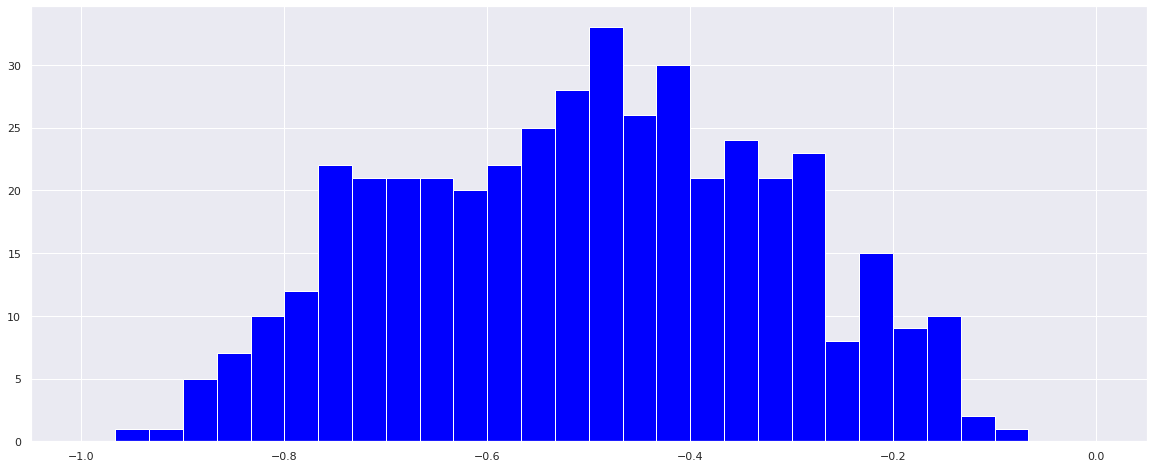

In [23]:
plot_confidence(y_test, preds, probs)

## Logistic Regression Model 3: 
# Rolling Average

In [24]:
all_games = pd.read_csv(root_path +'/data/all_games_ppmadf.csv')
all_games.GAME_DATE = pd.to_datetime(all_games.GAME_DATE)

df_2013 = get_season_by_year(2013, df=all_games)
df_2014 = get_season_by_year(2014, df=all_games)
df_2015 = get_season_by_year(2015, df=all_games)

In [25]:
def create_training_data(df=all_games):
  '''
  Create a dataframe for training/testing using the df argument.

  Returns a DataFrame.
  '''

  AWAY_TEAM_DICT = {
      'ATL' : 'AWAY_ATL',
      'BKN' : 'AWAY_BKN',
      'BOS' : 'AWAY_BOS', 
      'CHA' : 'AWAY_CHA', 
      'CHI' : 'AWAY_CHI', 
      'CLE' : 'AWAY_CLE', 
      'DAL' : 'AWAY_DAL', 
      'DEN' : 'AWAY_DEN', 
      'DET' : 'AWAY_DET', 
      'GSW' : 'AWAY_GSW', 
      'HOU' : 'AWAY_HOU', 
      'IND' : 'AWAY_IND', 
      'LAC' : 'AWAY_LAC', 
      'LAL' : 'AWAY_LAL', 
      'MEM' : 'AWAY_MEM', 
      'MIA' : 'AWAY_MIA', 
      'MIL' : 'AWAY_MIL', 
      'MIN' : 'AWAY_MIN', 
      'NOP' : 'AWAY_NOP', 
      'NYK' : 'AWAY_NYK', 
      'OKC' : 'AWAY_OKC', 
      'ORL' : 'AWAY_ORL', 
      'PHI' : 'AWAY_PHI', 
      'PHX' : 'AWAY_PHX', 
      'POR' : 'AWAY_POR', 
      'SAC' : 'AWAY_SAC', 
      'SAS' : 'AWAY_SAS', 
      'TOR' : 'AWAY_TOR', 
      'UTA' : 'AWAY_UTA', 
      'WAS' : 'AWAY_WAS',  
  }
  AWAY_TEAM = pd.get_dummies(df.AWAY_TEAM)
  AWAY_TEAM = AWAY_TEAM.rename(columns=AWAY_TEAM_DICT)

  HOME_TEAM = pd.get_dummies(df.HOME_TEAM)

  df = df.drop(columns=[
                        'GAME_DATE',
                        'GAME_ID',
                        'MATCHUP',
                        'HOME_TEAM',
                        'AWAY_TEAM'
                        ])

  df_model = pd.concat((
      HOME_TEAM, 
      AWAY_TEAM,
      df
  ), axis=1)
  
  return df_model

In [26]:
dft_2013 = create_training_data(df_2013)
dft_2014 = create_training_data(df_2014)
dft_2015 = create_training_data(df_2015)
df_all = create_training_data(all_games)

X_13 = dft_2013.drop(columns=['HOME_WIN'])
y_13 = dft_2013['HOME_WIN']

X_14 = dft_2014.drop(columns=['HOME_WIN'])
y_14 = dft_2014['HOME_WIN']

X_15 = dft_2015.drop(columns=['HOME_WIN'])
y_15 = dft_2015['HOME_WIN']

X_all = df_all.drop(columns=['HOME_WIN'])
y_all = df_all['HOME_WIN']

from sklearn import preprocessing
mms = preprocessing.MinMaxScaler()

# 2013 data
temp_df = X_13.copy()
for i in temp_df.columns[60:]:
  #print(i)
  X_13[i] = mms.fit_transform(temp_df[i].values.reshape(-1,1))

# 2014 data
temp_df = X_14.copy()
for i in temp_df.columns[60:]:
  #print(i)
  X_14[i] = mms.fit_transform(temp_df[i].values.reshape(-1,1))

# 2015 data
temp_df = X_15.copy()
for i in temp_df.columns[60:]:
  #print(i)
  X_15[i] = mms.fit_transform(temp_df[i].values.reshape(-1,1))

# 2013-2015
temp_df = X_all.copy()
for i in temp_df.columns[60:]:
  #print(i)
  X_all[i] = mms.fit_transform(temp_df[i].values.reshape(-1,1))


# merge 2 years for training
X_1314 = X_13.append(X_14)
y_1314 = y_13.append(y_14)


from sklearn.model_selection import train_test_split
test_size = 0.3
random_state = 101

X_train_13, X_test_13, y_train_13, y_test_13 = train_test_split(X_13, y_13, test_size=test_size, random_state=random_state)
X_train_14, X_test_14, y_train_14, y_test_14 = train_test_split(X_14, y_14, test_size=test_size, random_state=random_state)
X_train_15, X_test_15, y_train_15, y_test_15 = train_test_split(X_15, y_15, test_size=test_size, random_state=random_state)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=test_size, random_state=random_state)

X_train_1314, X_test_1314, y_train_1314, y_test_1314 = train_test_split(X_1314, y_1314, test_size=test_size, random_state=random_state)


In [27]:
from sklearn.linear_model import LogisticRegression
# simple logistic regression model used as a baseline classifier
clf_1314 = LogisticRegression(random_state=101, max_iter=1000).fit(X_train_1314, y_train_1314)

preds = clf_1314.predict(X_test_1314)
probs = clf_1314.predict_proba(X_test_1314)[:,1]
clf_1314.score(X_test_1314, y_test_1314)

0.6648122392211405

Mean confidence of error: -0.5068996809981365
Number of "strongly" incorrect (greater than 65% probability): 109 of 241 total incorrect.


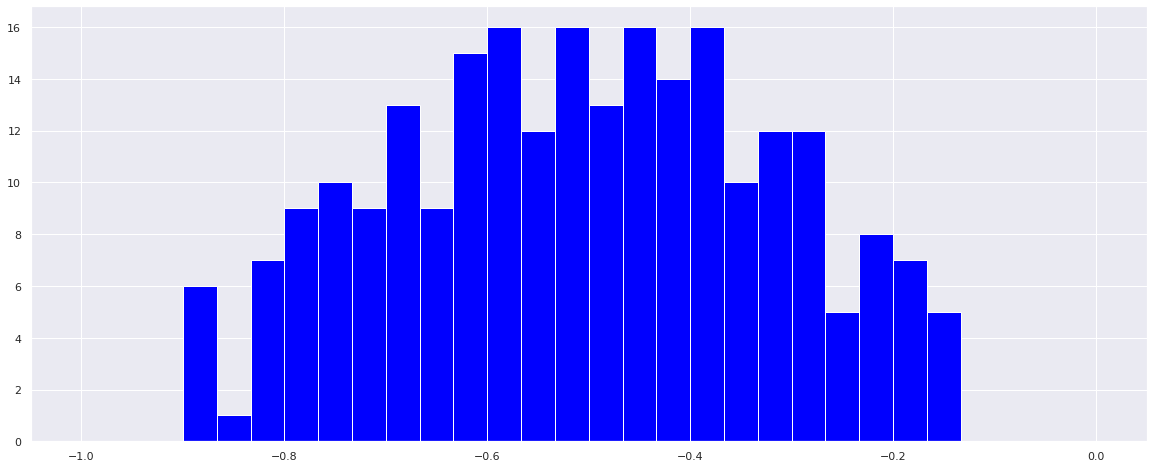

In [28]:
plot_confidence(y_test_1314, preds, probs)

In [29]:
clf_1314.score(X_train_15, y_train_15)

0.6283391405342624

Mean confidence of error: -0.49767176039935396
Number of "strongly" incorrect (greater than 65% probability): 149 of 320 total incorrect.


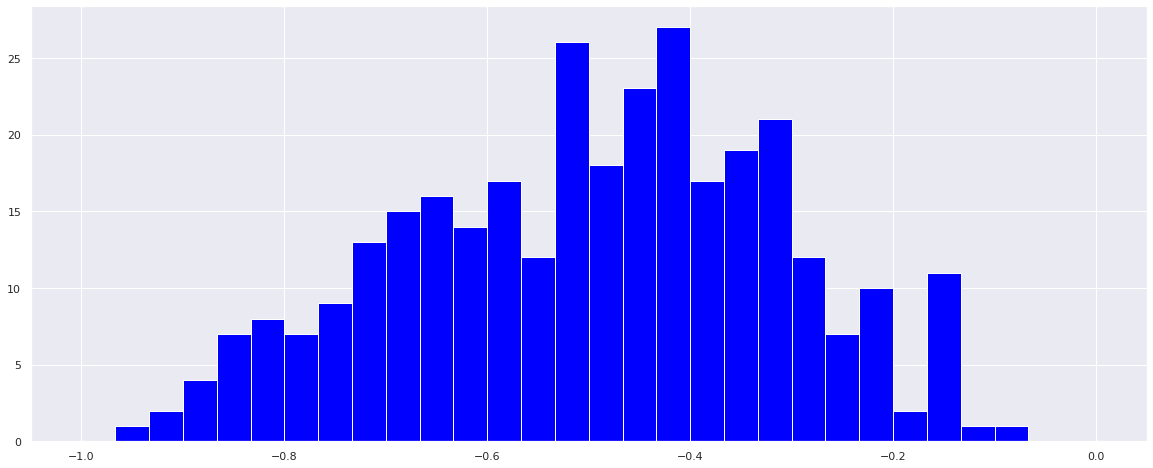

In [30]:
preds = clf_1314.predict(X_train_15)
probs = clf_1314.predict_proba(X_train_15)[:,1]
plot_confidence(y_train_15, preds, probs)

In [31]:
clf_all = LogisticRegression(random_state=101, max_iter=1000).fit(X_train_all, y_train_all)
clf_all.score(X_test_all, y_test_all)

0.6534926470588235

Mean confidence of error: -0.510999935176738
Number of "strongly" incorrect (greater than 65% probability): 147 of 377 total incorrect.


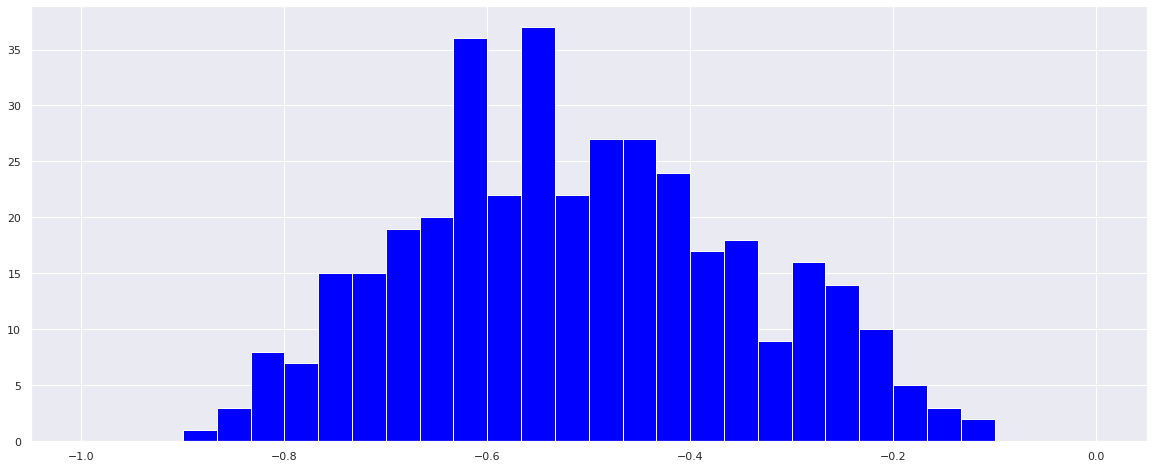

In [32]:
preds = clf_all.predict(X_test_all)
probs = clf_all.predict_proba(X_test_all)[:,1]
plot_confidence(y_test_all, preds, probs)

In [33]:
clf_1314 = LogisticRegression(random_state=101, max_iter=1000).fit(X_train_1314, y_train_1314)
clf_1314.score(X_test_1314, y_test_1314)

0.6648122392211405

Mean confidence of error: -0.5068996809981365
Number of "strongly" incorrect (greater than 65% probability): 109 of 241 total incorrect.


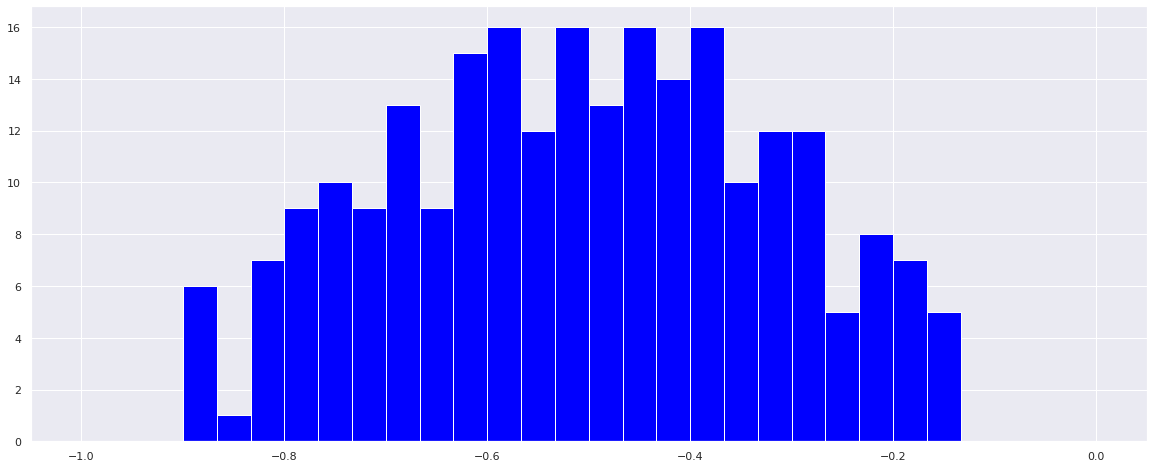

In [34]:
preds = clf_1314.predict(X_test_1314)
probs = clf_1314.predict_proba(X_test_1314)[:,1]
plot_confidence(y_test_1314, preds, probs)

In [35]:
preds = clf_1314.predict(X_train_15)
probs = clf_1314.predict_proba(X_train_15)[:,1]
clf_1314.score(X_train_15, y_train_15)

0.6283391405342624

Mean confidence of error: -0.49767176039935396
Number of "strongly" incorrect (greater than 65% probability): 149 of 320 total incorrect.


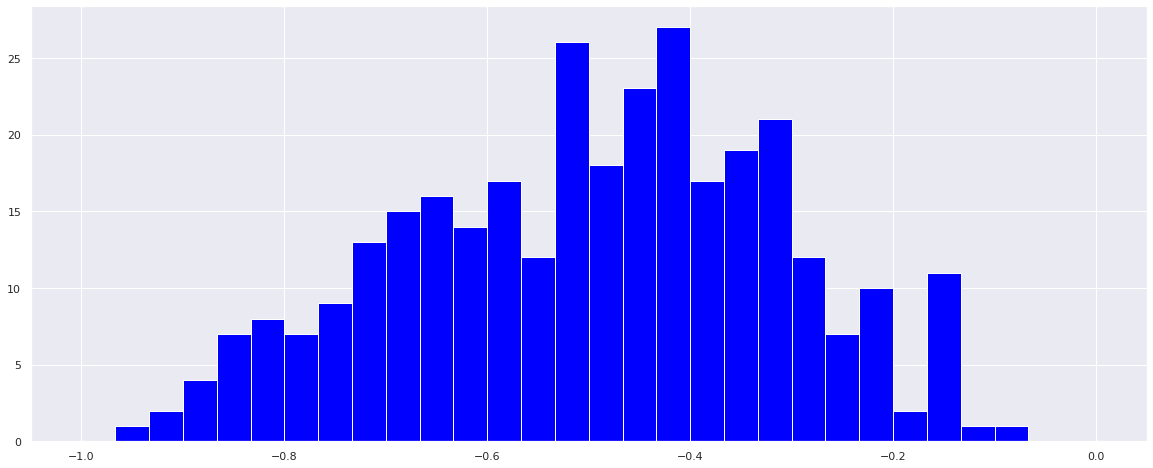

In [36]:
plot_confidence(y_train_15, preds, probs)

## Logistic Regression Model 4: 
# 2013-2014 Training Data

In this section I address the possibility that the training data being scrambled may have been affecting the accuracy of the model (in either a good or bad way).

I have organized the training data to consist of all of the 2013-2014 matches. The test data consists of all of the 2015 season game matches.

I am still using the Rolling Average data.

In [37]:
train_data = pd.read_csv(root_path +'/data/train_data_ppmadf.csv')
test_data= pd.read_csv(root_path +'/data/test_data_ppmadf.csv')

X_train = train_data.drop(columns=['HOME_WIN'])
y_train = train_data['HOME_WIN']

X_test = test_data.drop(columns=['HOME_WIN'])
y_test = test_data['HOME_WIN']

In [38]:
# simple logistic regression model used as a baseline classifier
clf = LogisticRegression(random_state=101, max_iter=1000).fit(X_train, y_train)

0.6430894308943089
Mean confidence of error: -0.5038249168502376
Number of "strongly" incorrect (greater than 65% probability): 213 of 439 total incorrect.


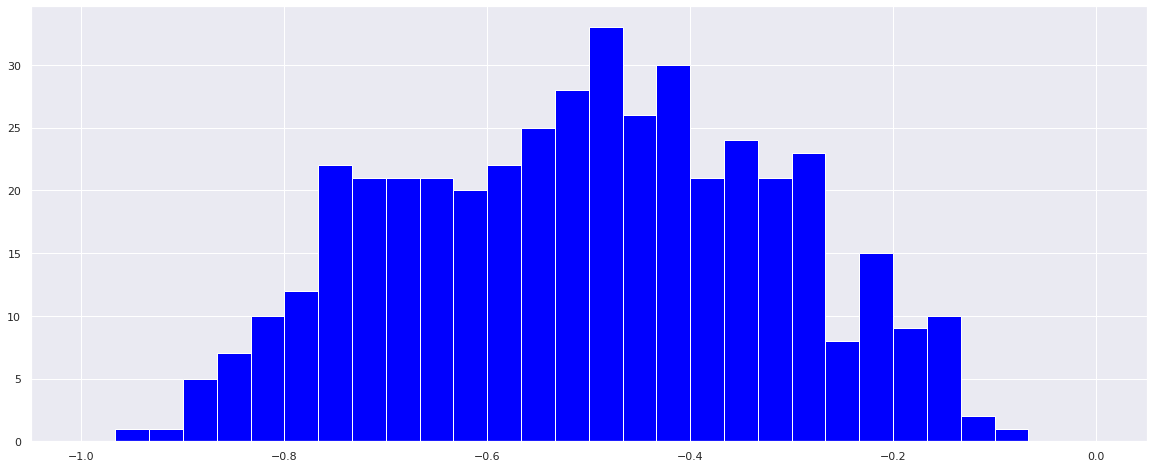

In [39]:
preds = clf.predict(X_test)
probs = clf.predict_proba(X_test)[:,1]
print(clf.score(X_test, y_test))
plot_confidence(y_test, preds, probs)

## Logistic Regression Model 5: 
# 2013-2014 Training Data - Revised Columns

In this section I try removing some of the stats columns to see if there's any improvement. 

In [41]:
X_train.columns

Index(['ATL', 'BKN', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW',
       'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK',
       'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS',
       'AWAY_ATL', 'AWAY_BKN', 'AWAY_BOS', 'AWAY_CHA', 'AWAY_CHI', 'AWAY_CLE',
       'AWAY_DAL', 'AWAY_DEN', 'AWAY_DET', 'AWAY_GSW', 'AWAY_HOU', 'AWAY_IND',
       'AWAY_LAC', 'AWAY_LAL', 'AWAY_MEM', 'AWAY_MIA', 'AWAY_MIL', 'AWAY_MIN',
       'AWAY_NOP', 'AWAY_NYK', 'AWAY_OKC', 'AWAY_ORL', 'AWAY_PHI', 'AWAY_PHX',
       'AWAY_POR', 'AWAY_SAC', 'AWAY_SAS', 'AWAY_TOR', 'AWAY_UTA', 'AWAY_WAS',
       'AWAY_RA_AST', 'AWAY_RA_BLK', 'AWAY_RA_DREB', 'AWAY_RA_FG3A',
       'AWAY_RA_FG3M', 'AWAY_RA_FG3_PCT', 'AWAY_RA_FGA', 'AWAY_RA_FGM',
       'AWAY_RA_FG_PCT', 'AWAY_RA_FTA', 'AWAY_RA_FTM', 'AWAY_RA_FT_PCT',
       'AWAY_RA_OREB', 'AWAY_RA_PF', 'AWAY_RA_PLUS_MINUS', 'AWAY_RA_PTS',
       'AWAY_RA_REB', 'AWAY_RA_STL', 'AWAY_RA_TOV', 'HOME_RA_AST',
       'HOME_RA_BLK

In [45]:
cols_to_drop = [
                'AWAY_RA_AST',
                'HOME_RA_AST',
                'AWAY_RA_BLK',
                'HOME_RA_BLK',
                'AWAY_RA_DREB',
                'HOME_RA_DREB',
                'AWAY_RA_FG3A',
                'HOME_RA_FG3A',
                'AWAY_RA_FGA',
                'HOME_RA_FGA',
                'AWAY_RA_FGM',
                'HOME_RA_FGM',
                'AWAY_RA_FG3M',
                'HOME_RA_FG3M',
                'AWAY_RA_OREB',
                'HOME_RA_OREB',
                'AWAY_RA_FTA',
                'HOME_RA_FTA',
                'AWAY_RA_FTM',
                'HOME_RA_FTM',
                'AWAY_RA_PF',
                'HOME_RA_PF',
]

X_train_revised = X_train.drop(columns=cols_to_drop)
X_test_revised = X_test.drop(columns=cols_to_drop)

In [47]:
# simple logistic regression model used as a baseline classifier
clf = LogisticRegression(random_state=101, max_iter=1000).fit(X_train_revised, y_train)

0.6882303839732888
Mean confidence of error: -0.513498803696523
Number of "strongly" incorrect (greater than 65% probability): 282 of 747 total incorrect.


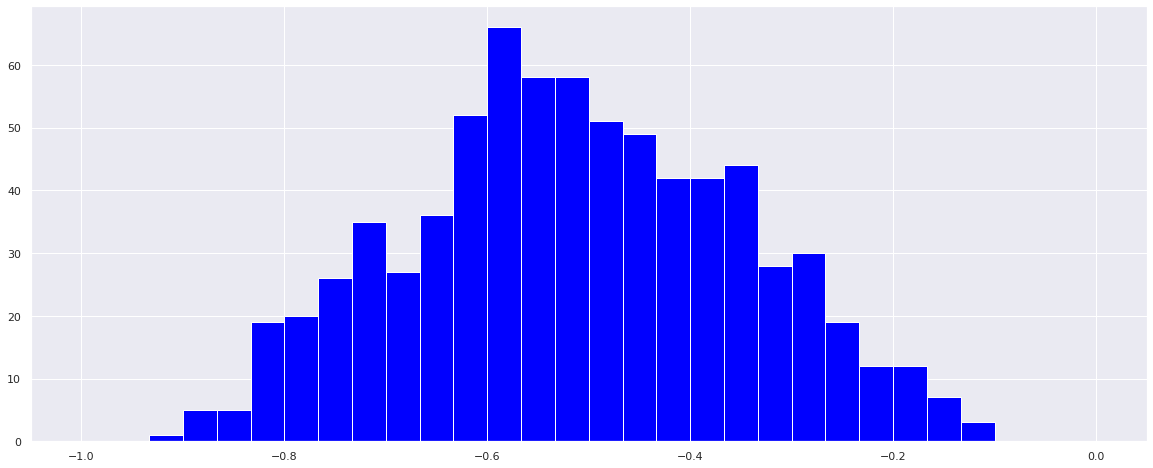

In [49]:
preds = clf.predict(X_train_revised)
probs = clf.predict_proba(X_train_revised)[:,1]
print(clf.score(X_train_revised, y_train))
plot_confidence(y_train, preds, probs)

0.6528455284552845
Mean confidence of error: -0.5034621713217198
Number of "strongly" incorrect (greater than 65% probability): 209 of 427 total incorrect.


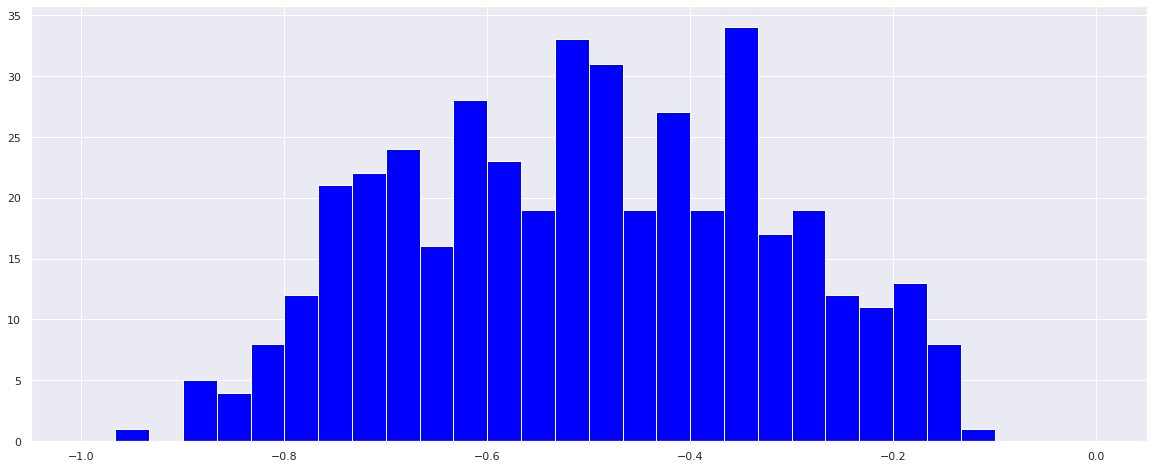

In [50]:
preds = clf.predict(X_test_revised)
probs = clf.predict_proba(X_test_revised)[:,1]
print(clf.score(X_test_revised, y_test))
plot_confidence(y_test, preds, probs)